<a href="https://colab.research.google.com/github/tntly/machine-learning-projects/blob/main/generative-models/vae/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoders (VAE)

> Author: Tien Ly  
> CS 271: Topics in Machine Learning - Spring 2025 at San Jose State University

This notebook provides an introduction to Variational Autoencoders (VAEs), a generative model commonly used in unsupervised learning to learn representations of data. Using TensorFlow and the Fashion MNIST dataset, the notebook demonstrates the key steps involved in training a VAE, including:

* Preparing and preprocessing the data
* Defining the encoder and decoder components of the VAE architecture
* Training the model by optimizing the evidence lower bound (ELBO)
* Evaluating and visualizing the learned latent representations and generated samples

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)
from keras import backend as K

from scipy.stats import norm

## Parameters

In [ ]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

## Prepare the data

In [ ]:
# Load the data
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

In [ ]:
# Preprocess the data
def preprocess(imgs):
  """
  Normalize and reshape the images
  """
  imgs = imgs.astype("float32") / 255.0
  imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
  imgs = np.expand_dims(imgs, -1)
  return imgs

train_images = preprocess(train_images)
test_images = preprocess(test_images)

In [ ]:
# Show some items of clothing from the training set
display(train_images)

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

## Build the variational autoencoder

In [ ]:
# Reparameterization trick
class Sampling(layers.Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = x.shape[1:] # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 32, 32, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 16, 16, 32)     │            320 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 8, 8, 64)       │         18,496 │ conv2d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 4, 4, 128)      │         73,856 │ conv2d_16[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 2048)           │              0 │ conv2d_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │          4,098 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │          4,098 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_1 (Sampling)     │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2D)              │ (None, 32, 32, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class VAE(models.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.total_loss_tracker = metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = metrics.Mean(
        name="reconstruction_loss"
    )
    self.kl_loss_tracker = metrics.Mean(name="kl_loss")

  @property
  def metrics(self):
    return [
        self.total_loss_tracker,
        self.reconstruction_loss_tracker,
        self.kl_loss_tracker,
    ]

  def call(self, inputs):
    """Call the model on a particular input."""
    z_mean, z_log_var, z = encoder(inputs)
    reconstruction = decoder(z)
    return z_mean, z_log_var, reconstruction

  def train_step(self, data):
    """Step run during training."""
    with tf.GradientTape() as tape:
      z_mean, z_log_var, reconstruction = self(data)
      reconstruction_loss = tf.reduce_mean(
          BETA
          * losses.binary_crossentropy(
              data, reconstruction, axis=(1, 2, 3)
          )
      )
      kl_loss = tf.reduce_mean(
          tf.reduce_sum(
              -0.5
              * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
              axis=1,
          )
      )
      total_loss = reconstruction_loss + kl_loss

    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)

    return {m.name: m.result() for m in self.metrics}

  def test_step(self, data):
    """Step run during validation."""
    if isinstance(data, tuple):
      data = data[0]

    z_mean, z_log_var, reconstruction = self(data)
    reconstruction_loss = tf.reduce_mean(
        BETA
        * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
    )
    kl_loss = tf.reduce_mean(
        tf.reduce_sum(
            -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
            axis=1,
        )
    )
    total_loss = reconstruction_loss + kl_loss

    return {
        "loss": total_loss,
        "reconstruction_loss": reconstruction_loss,
        "kl_loss": kl_loss,
    }

In [ ]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

## Train the variational autoencoder

In [ ]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [ ]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint.keras",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [ ]:
vae.fit(
    train_images,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(test_images, test_images),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 226s 366ms/step - kl_loss: 3.3889 - reconstruction_loss: 198.9586 - total_loss: 202.3474 - val_kl_loss: 4.8362 - val_loss: 141.4092 - val_reconstruction_loss: 136.5730
Epoch 2/5


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 222s 371ms/step - kl_loss: 4.9025 - reconstruction_loss: 131.2062 - total_loss: 136.1087 - val_kl_loss: 4.9188 - val_loss: 137.5404 - val_reconstruction_loss: 132.6216
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 278s 398ms/step - kl_loss: 5.0108 - reconstruction_loss: 129.3040 - total_loss: 134.3148 - val_kl_loss: 5.1357 - val_loss: 136.8448 - val_reconstruction_loss: 131.7091
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 264s 402ms/step - kl_loss: 5.0724 - reconstruction_loss: 127.9397 - total_loss: 133.0120 - val_kl_loss: 5.1920 - val_loss: 136.3729 - val_reconstruction_loss: 131.1809
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 253s 388ms/step - kl_loss: 5.1344 - reconstruction_loss: 127.3339 - total_loss: 132.4684 - val_kl_loss: 5.5228 - val_loss: 135.7796 - val_reconstruction_loss: 130.2567


In [ ]:
# Create the 'models' directory if it doesn't exist
os.makedirs("./models", exist_ok=True)

# Save the final models
vae.save("./models/vae.keras")
encoder.save("./models/encoder.keras")
decoder.save("./models/decoder.keras")

## Reconstruct using the variational autoencoder <a name="reconstruct"></a>

In [ ]:
# Select a subset of the test set
n_to_predict = 5000
example_images = test_images[:n_to_predict]
example_labels = test_labels[:n_to_predict]

In [ ]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step


In [ ]:
print("Example real clothing items")
display(example_images)

Example real clothing items


array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.        ],
         [0.        ],
         [0.  

In [ ]:
print("Reconstructions")
display(reconstructions)

Reconstructions


array([[[[1.40689677e-04],
         [2.70627261e-05],
         [5.80702799e-05],
         ...,
         [7.80769199e-07],
         [1.66549853e-06],
         [1.25095597e-04]],

        [[6.54109363e-06],
         [7.59792556e-07],
         [2.85228134e-06],
         ...,
         [9.72097638e-08],
         [5.30660742e-08],
         [1.15412995e-05]],

        [[7.01915178e-06],
         [7.63963897e-07],
         [9.36979814e-06],
         ...,
         [1.87647147e-05],
         [3.09634606e-06],
         [5.55051156e-05]],

        ...,

        [[1.27423766e-06],
         [1.51275998e-07],
         [2.33869378e-06],
         ...,
         [1.07466485e-06],
         [6.49472497e-07],
         [2.32335387e-05]],

        [[1.89493869e-06],
         [2.77332020e-07],
         [7.01777890e-06],
         ...,
         [1.11490908e-06],
         [2.61922452e-07],
         [1.51760123e-05]],

        [[1.78561153e-04],
         [2.25271106e-05],
         [1.31048815e-04],
         ...,
 

## Embed using the encoder

In [ ]:
# Encode the example images
z_mean, z_var, z = encoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:
# Some examples of the embeddings
print(z[:10])

[[ 0.44678235  1.2512313 ]
 [ 0.8011191  -1.4638498 ]
 [-2.5285566  -0.6023893 ]
 [-1.9631901   0.30747128]
 [ 0.4372508  -0.34440863]
 [-1.6081746  -0.35376775]
 [-0.36468077 -0.0951769 ]
 [ 0.2394061  -0.413162  ]
 [-0.65164554  2.5194972 ]
 [ 0.74109435  1.964904  ]]


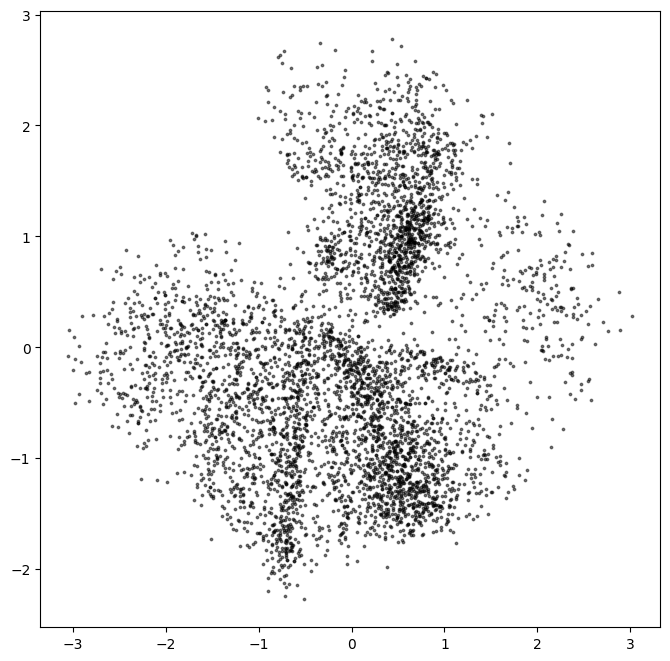

In [ ]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

## Generate using the decoder

In [ ]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [ ]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


In [ ]:
# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

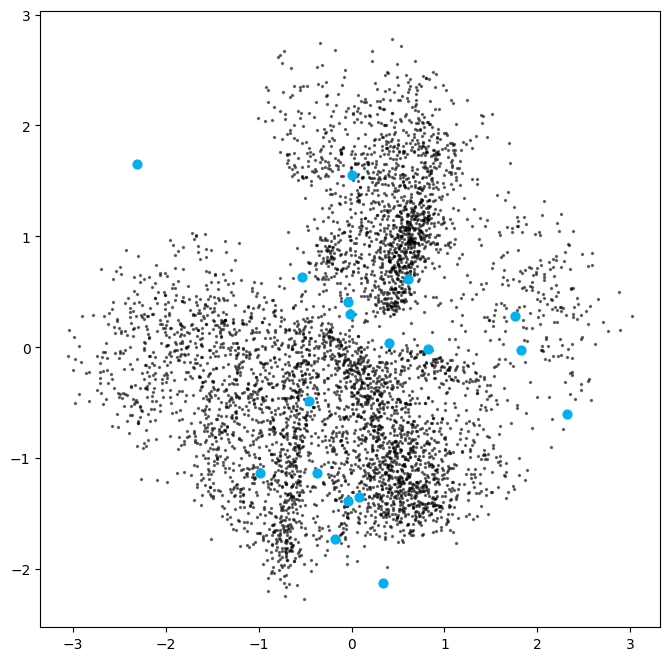

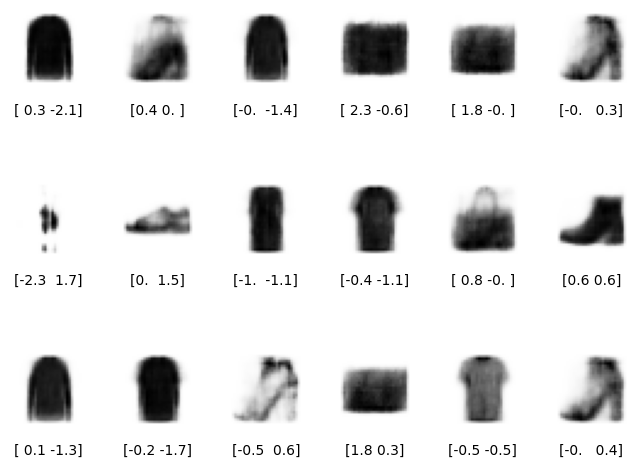

In [ ]:
"""
  Draw a plot of the original embeddings and the newly generated points in the
  latent space
"""
figsize = 8
plt.figure(figsize=(figsize, figsize))

plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
  ax = fig.add_subplot(grid_height, grid_width, i + 1)
  ax.axis("off")
  ax.text(
      0.5,
      -0.35,
      str(np.round(z_sample[i, :], 1)),
      fontsize=10,
      ha="center",
      transform=ax.transAxes,
  )
  ax.imshow(reconstructions[i, :, :], cmap="Greys")

## Explore the latent space

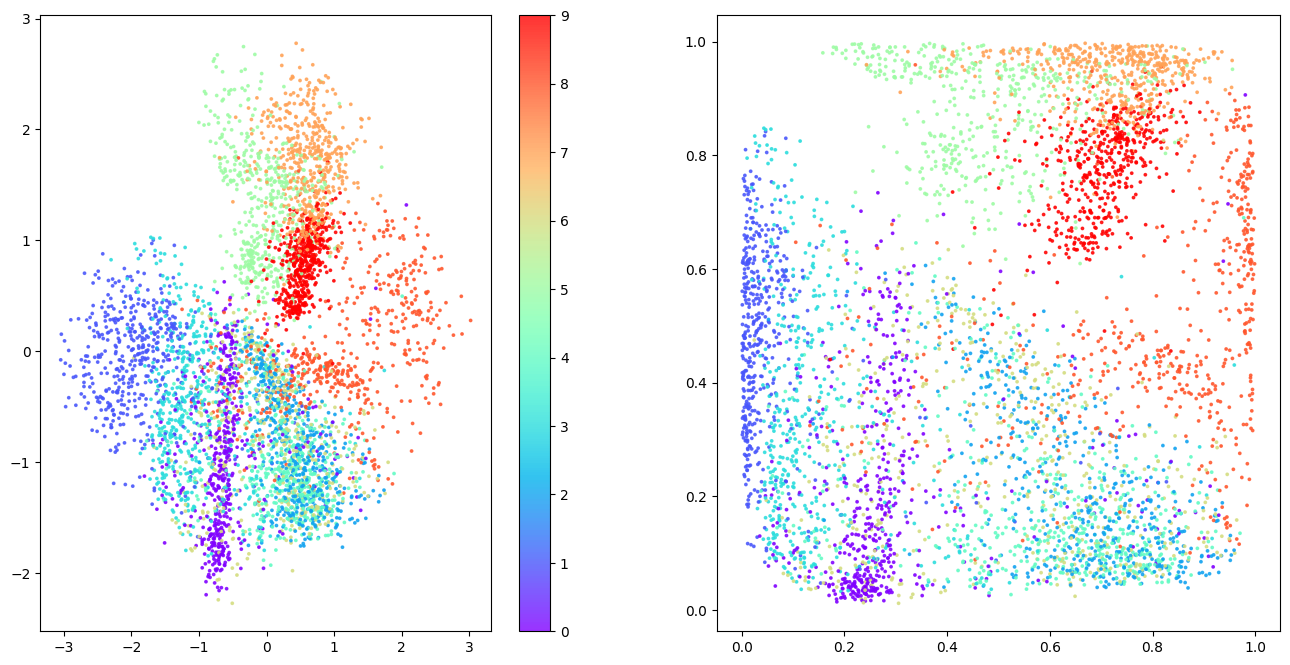

In [ ]:
# Color the embeddings by their label (clothing type - see table)
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))

ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)

ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

| ID | Clothing Label |
| :- | :- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


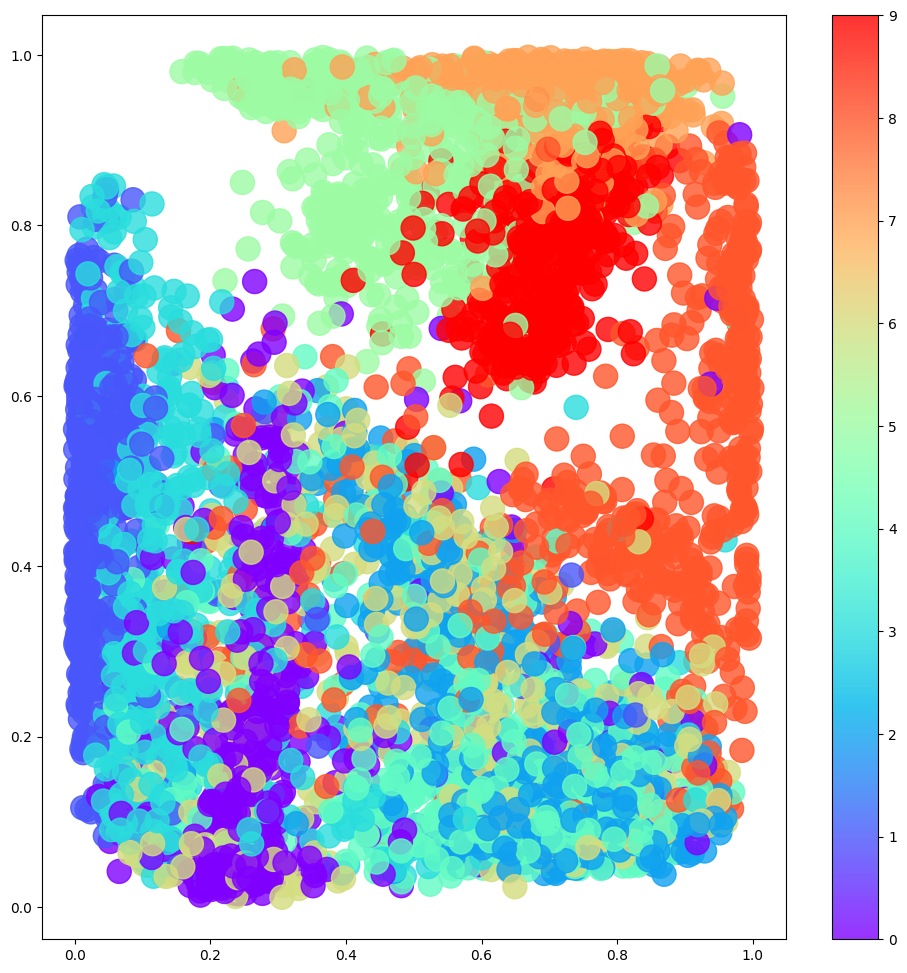

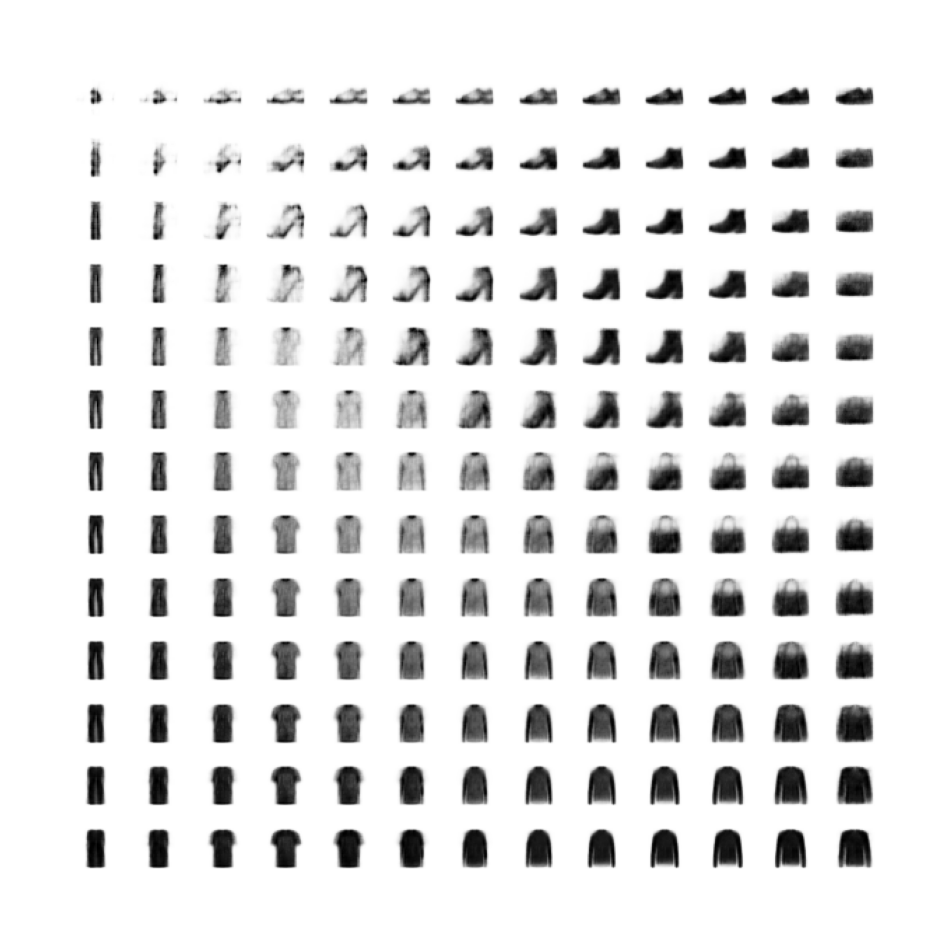

In [ ]:
# Color the embeddings by their label (clothing type)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
  ax = fig.add_subplot(grid_size, grid_size, i + 1)
  ax.axis("off")
  ax.imshow(reconstructions[i, :, :], cmap="Greys")